<a href="https://colab.research.google.com/github/RoetGer/decisions-under-uncertainty/blob/main/deep_hedging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

Let's start with some helper functions to deal with Black-Scholes based option pricing (from Tomas Björk's book "Arbitrage Theory in Continuous Time"):

In [14]:
def compute_d1(S, K, r, sigma, T, t):
    dt = T - t
    return (tf.math.log(S/K) + (r + sigma**2/2)*dt) / (sigma * tf.sqrt(dt))

def compute_d2(S, K, r, sigma, T, t):
    dt = T - t
    return compute_d1(S, K, r, sigma, T, t) - sigma * tf.sqrt(dt)

def compute_bs_price(S, K, r, sigma, T, t):
    normal = tfd.Normal(loc=0., scale=1.)
    dt = T - t

    d1 = compute_d1(S, K, r, sigma, T, t)
    d2 = d1 - sigma * tf.sqrt(dt)

    price = S*normal.cdf(d1) - tf.exp(-r*dt)*K*normal.cdf(d2)

    return price

def compute_delta(S, K, r, sigma, T, t):
    normal = tfd.Normal(loc=0., scale=1.)
    return normal.cdf(compute_d1(S, K, r, sigma, T, t))

def compute_gamma(S, K, r, sigma, T, t):
    normal = tfd.Normal(loc=0., scale=1.)
    dt = T - t
    d1 = compute_d1(S, K, r, sigma, T, t)
    return normal.prob(d1) / (S*sigma*tf.sqrt(dt))

def compute_rho(S, K, r, sigma, T, t):
    normal = tfd.Normal(loc=0., scale=1.)
    dt = T - t
    d2 = compute_d2(S, K, r, sigma, T, t)
    return K*dt*tf.exp(-r*dt)*normal.cdf(d2)

def compute_theta(S, K, r, sigma, T, t):
    normal = tfd.Normal(loc=0., scale=1.)
    dt = T - t
    d1 = compute_d1(S, K, r, sigma, T, t)
    d2 = d1 - sigma * tf.sqrt(dt)
    theta = (
        - S*normal.prob(d1)*sigma / (2*tf.sqrt(dt))
        - r*K*tf.exp(-r*dt)*normal.cdf(d2)
    )

    return theta

def compute_vega(S, K, r, sigma, T, t):
    normal = tfd.Normal(loc=0., scale=1.)
    dt = T - t
    d1 = compute_d1(S, K, r, sigma, T, t)
    return S*normal.prob(d1)*tf.sqrt(dt)

In [15]:
print("option price:", compute_bs_price(100, 100, 0.01, 1., 10., 1.))
print("delta:", compute_delta(100, 100, 0.01, 1., 10., 1.))
print("gamma:", compute_gamma(100, 100, 0.01, 1., 10., 1.))
print("rho:", compute_rho(100, 100, 0.01, 1., 10., 1.))
print("theta:", compute_theta(100, 100, 0.01, 1., 10., 1.))
print("vega:", compute_vega(100, 100, 0.01, 1., 10., 1.))

option price: tf.Tensor(87.23028, shape=(), dtype=float32)
delta: tf.Tensor(0.93699163, shape=(), dtype=float32)
gamma: tf.Tensor(0.0004125426, shape=(), dtype=float32)
rho: tf.Tensor(58.21999, shape=(), dtype=float32)
theta: tf.Tensor(-2.1274018, shape=(), dtype=float32)
vega: tf.Tensor(37.128834, shape=(), dtype=float32)


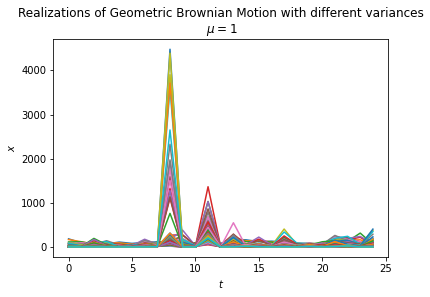

In [17]:
x = sample_geom_brownian_motion(25, 100, dt=0.1)

plt.plot(100*x)
#plt.legend(np.round(sigma, 2))
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title(
    "Realizations of Geometric Brownian Motion with different variances\n $\mu=1$"
)
plt.show()


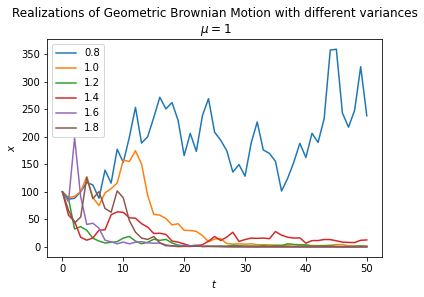

In [13]:
import numpy as np
import matplotlib.pyplot as plt

mu = 0.01
n = 50
dt = 0.1
x0 = 100
#np.random.seed(1)

sigma = np.arange(0.8, 2, 0.2)

x = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.normal(0, np.sqrt(dt), size=(len(sigma), n)).T
)
x = np.vstack([np.ones(len(sigma)), x])
x = x0 * x.cumprod(axis=0)

plt.plot(x)
plt.legend(np.round(sigma, 2))
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title(
    "Realizations of Geometric Brownian Motion with different variances\n $\mu=1$"
)
plt.show()
